In [3]:
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px

### Load data

In [4]:
data = pd.read_csv('billboard_24years_lyrics_spotify_with_genres.csv')

# Remove rows containing NaN values in the 'genre'
data = data.dropna(subset=['genre'])

In [5]:
## Make data frame with all data
data_all = data.copy()

In [6]:
## Make data frame with single entry per songurl
data_single = data.copy()

# Songs that appear more than once in the dataset
duplicated_songurls = data[data.duplicated(subset=['songurl'], keep=False)]['songurl'].unique()

for songurl in duplicated_songurls[:10]:
    rows = data[data['songurl'] == songurl]
    
    # Combine rows by collecting band_singer and url as lists of unique elements
    combined_band_singer = list(rows['band_singer'].unique())
    combined_url = list(rows['url'].unique())

    danceability = rows['danceability'].mean()
    energy = rows['energy'].mean()
    key = rows['key'].mean()
    loudness = rows['loudness'].mean()
    mode = rows['mode'].mean()
    speechiness = rows['speechiness'].mean()
    acousticness = rows['acousticness'].mean()
    instrumentalness = rows['instrumentalness'].mean()
    liveness = rows['liveness'].mean()
    valence = rows['valence'].mean()
    tempo = rows['tempo'].mean()
    duration_ms = rows['duration_ms'].mean()


    # Create a new row with combined information
    new_row = rows.iloc[0].copy()
    new_row['band_singer'] = combined_band_singer
    new_row['url'] = combined_url
    new_row['danceability'] = danceability
    new_row['energy'] = energy
    new_row['key'] = key
    new_row['loudness'] = loudness
    new_row['mode'] = mode
    new_row['speechiness'] = speechiness
    new_row['acousticness'] = acousticness
    new_row['instrumentalness'] = instrumentalness
    new_row['liveness'] = liveness
    new_row['valence'] = valence
    new_row['tempo'] = tempo
    new_row['duration_ms'] = duration_ms

    # Drop the original rows and append the new combined row
    data_single = data_single[data_single['songurl'] != songurl]
    data_single.loc[len(data_single)] = new_row

# Sort data_single by ranking
data_single = data_single.sort_values(by='ranking').reset_index(drop=True)

### Basic statistics

In [7]:
## Basic statistics of genres
df_genres = data_single[data_single['genre'].apply(bool)].reset_index(drop=True)

df_genres['genre'] = (
    df_genres['genre']
      .astype(str)
      .apply(lambda x: [g.strip() for g in x.split(',')] if ',' in x else [x.strip()])
)


Number of artists with genres: 3057
Average number of genres per artist: 2.1995420346745176
Total distinct genres: 327


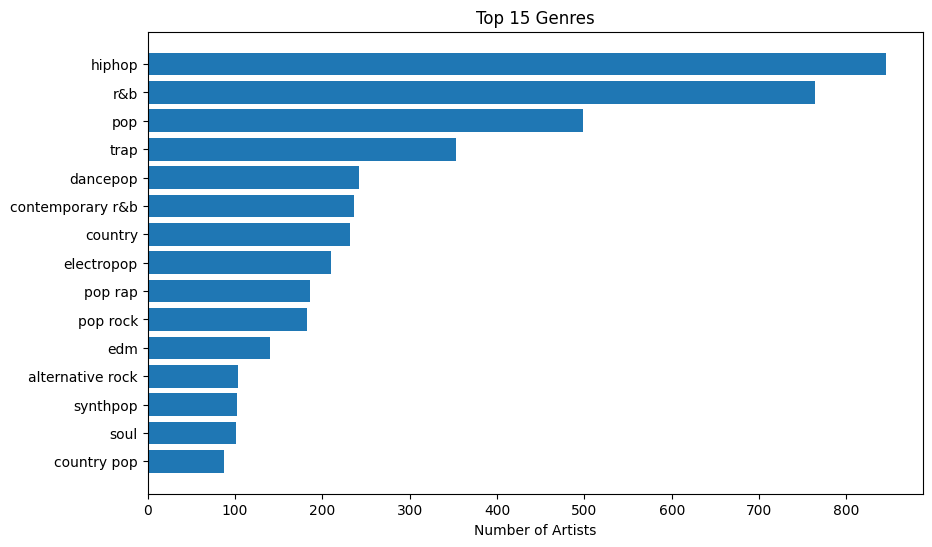

In [8]:

# --- Stats ---
num_artists_with_genres = len(df_genres)
avg_genres_per_artist = sum(len(genres) for genres in df_genres['genre']) / num_artists_with_genres
all_genres = [g for genres in df_genres['genre'] for g in genres]
num_distinct_genres = len(set(all_genres))
genre_counts = Counter(all_genres)

print("Number of artists with genres:", num_artists_with_genres)
print("Average number of genres per artist:", avg_genres_per_artist)
print("Total distinct genres:", num_distinct_genres)

# --- Histogram (top 15 genres) ---
if genre_counts:
    top = genre_counts.most_common(15)
    names, counts = zip(*top)
    plt.figure(figsize=(10,6))
    plt.barh(names[::-1], counts[::-1])
    plt.xlabel("Number of Artists")
    plt.title("Top 15 Genres")
    plt.show()

### Networks 

In [13]:
import networkx as nx

# Read emotion data
df_emo = pd.read_csv(
    'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'association']
)

In [10]:
## Remove genres with less than 5 artists
filtered_genres = {genre for genre, count in genre_counts.items() if count >= 5}
df_genres['genre'] = df_genres['genre'].apply(lambda genres: [g for g in genres if g in filtered_genres])
df_genres = df_genres[df_genres['genre'].apply(bool)].reset_index(drop=True)

In [19]:
from collections import defaultdict, Counter

def map_song_to_emotions_count(song_lyrics: str, df_emo: pd.DataFrame) -> dict:
    """
    Map words in a song's lyrics to emotions and count frequency.
    Returns a dictionary: emotion -> count of words
    """
    # Prepare mapping: word -> list of emotions
    word_to_emotions = defaultdict(list)
    for _, row in df_emo.iterrows():
        word_to_emotions[row['word']].append(row['emotion'])

    # Tokenize lyrics
    words = song_lyrics.lower().split()

    # Count occurrences of each emotion
    emotion_counts = Counter()
    for word in words:
        if word in word_to_emotions:
            for emotion in word_to_emotions[word]:
                emotion_counts[emotion] += 1

    return dict(emotion_counts)

# Function for overall emotion mapping for a song, positive = 1 and negative = -1
def map_song_to_emotions_overall(song_lyrics: str, df_emo: pd.DataFrame) -> dict:
    """
    Map words in a song's lyrics to emotions and provide overall sentiment.
    Returns a dictionary: emotion -> overall sentiment (1 for positive, -1 for negative)
    """
    # Prepare mapping: word -> list of (emotion, association)
    word_to_emotions = defaultdict(list)
    for _, row in df_emo.iterrows():
        word_to_emotions[row['word']].append((row['emotion'], row['association']))

    # Tokenize lyrics
    words = song_lyrics.lower().split()

    # Overall sentiment for each emotion
    emotion_overall = defaultdict(int)
    for word in words:
        if word in word_to_emotions:
            for emotion, association in word_to_emotions[word]:
                if association == 1:
                    emotion_overall[emotion] += 1
                elif association == 0:
                    emotion_overall[emotion] -= 1

    return dict(emotion_overall)



# Test the function
df_emo_ones = df_emo[df_emo['association'] == 1]
example_lyrics = df_genres['lyrics'][1]  # first song
emotion_counts = map_song_to_emotions_count(example_lyrics, df_emo_ones)
emotion_overall = map_song_to_emotions_overall(example_lyrics, df_emo_ones)
print(emotion_counts) 
print(emotion_overall)

{'trust': 5, 'anger': 1, 'negative': 1, 'joy': 1, 'positive': 1}
{'trust': 5, 'anger': 1, 'negative': 1, 'joy': 1, 'positive': 1}


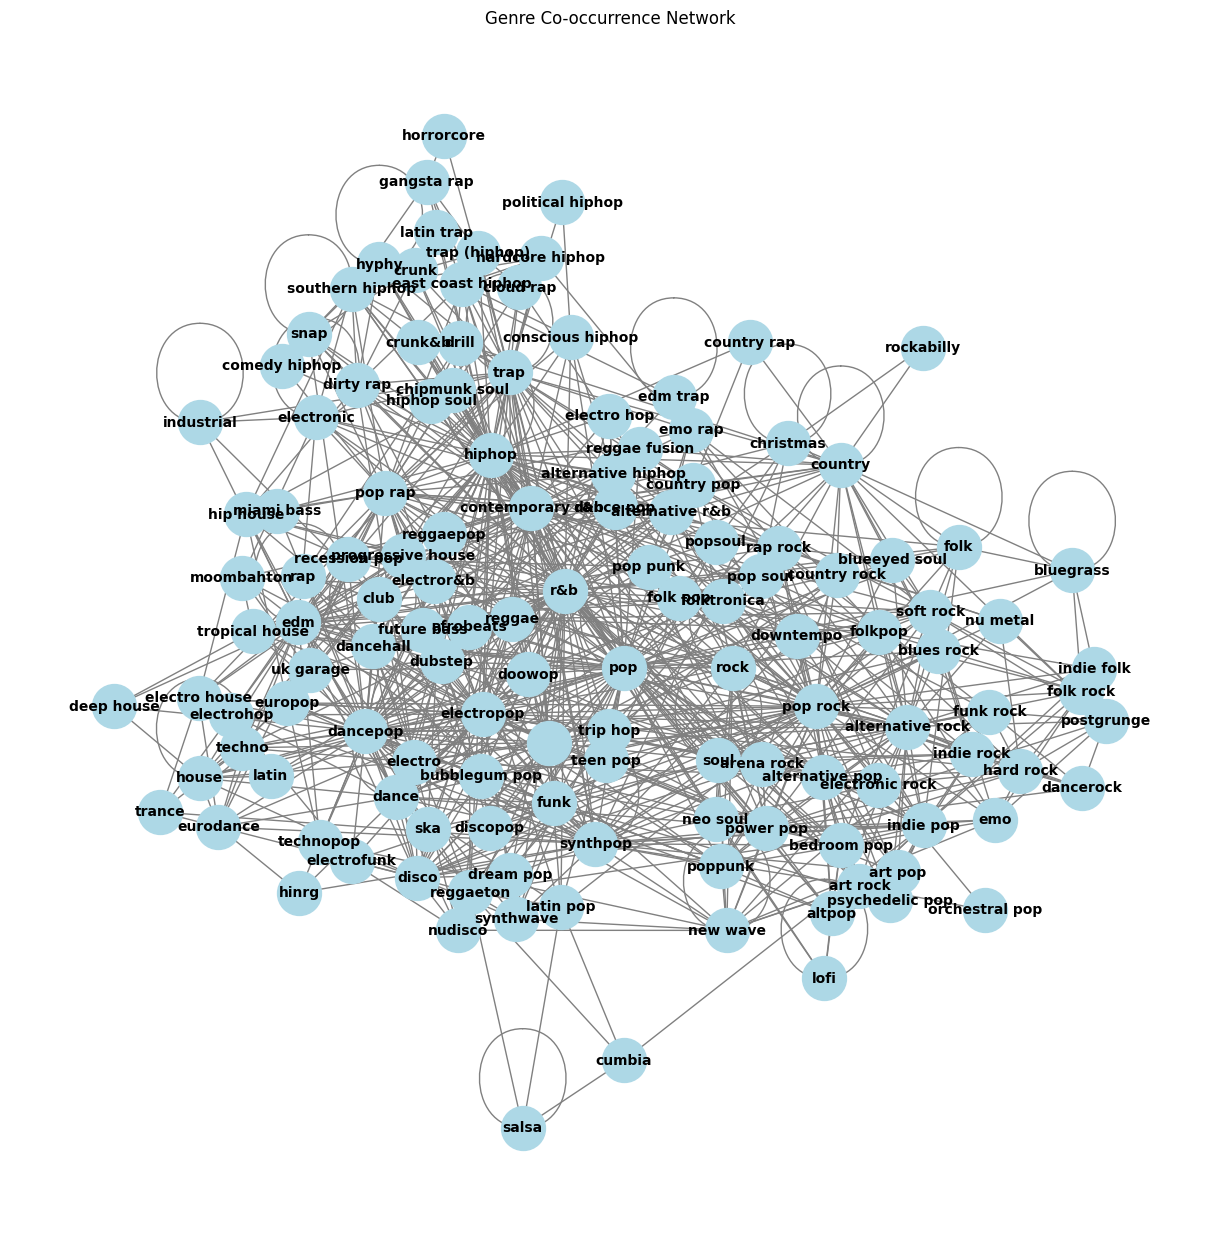

In [11]:
## Create graph with genres as nodes and links being the artist with both genres
G = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for i in range(len(genres)):
            for j in range(i + 1, len(genres)):
                genre1 = genres[i]
                genre2 = genres[j]
                if G.has_edge(genre1, genre2):
                    G[genre1][genre2]['weight'] += 1
                else:
                    G.add_edge(genre1, genre2, weight=1)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G, max_iter=1000)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
edge_weights = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
plt.title("Genre Co-occurrence Network")
plt.show()
